In [2]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('ticks')

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

##### Read files and select drugs

In [3]:
# log2_median_ic50, log2_median_ic50_9f, log2_median_ic50_hn, log2_median_ic50_3f_hn, log2_median_ic50_9f_hn, log2_max_conc, log2_median_ic50_3f_hn
ref_type = 'log2_median_ic50_hn' # log2_median_ic50_3f_hn | log2_median_ic50_hn
model_name = 'hn_drug_cw_dw10_100000_model2' # hn_drug_cw_dw10_100000_model | hn_drug_cw_dw1_100000_model | hn_drug_cw_dwsim10_100000_model

# for each patient, if cell cluster is less than 5%, then we don't consider that cluster 
freq_cutoff = 0.05

# shift the dosage as GDSC experiment (Syto60) is less sensitive
dosage_shifted = False

In [4]:
drug_info_df = pd.read_csv('../preprocessed_data/GDSC/hn_drug_stat.csv', index_col=0)
drug_info_df.index = drug_info_df.index.astype(str)

drug_id_name_dict = dict(zip(drug_info_df.index, drug_info_df['Drug Name']))
print (drug_info_df.shape)

(81, 27)


In [5]:
tested_drug_list = [1032, 1007, 133, 201, 1010] + [182, 301, 302]
[d for d in tested_drug_list if d not in drug_info_df.index.astype(int)]

[]

##### Read predicted IC50

In [6]:
norm_type = 'TPM'

In [7]:
cadrres_cluster_df = pd.read_csv('../result/HN_model/{}/pred_gdsc_no_bias_{}.csv'.format(norm_type, model_name), index_col=0)
out_dir = '../result/HN_model/{}/'.format(norm_type)

In [8]:
cadrres_cluster_df.head()

,1001,1003,1004,1006,1007,1010,1012,1014,1015,1016,...,299,301,302,303,305,306,308,328,331,346
A1,10.420753,-4.931614,-6.004500,1.020800,-6.907026,0.010804,0.767327,2.669532,3.557212,-1.827517,...,0.623491,2.509283,0.253886,3.219520,3.715341,2.516973,-0.655629,-1.366619,1.653326,-3.889950
A2,10.029803,-6.648713,-6.930798,-0.166377,-7.378364,0.097552,0.091080,2.163354,3.025933,-2.208191,...,0.772386,2.292860,0.609074,2.997777,3.321205,2.365288,-1.005312,-2.153061,1.553563,-4.294621
B1,10.999528,-4.828735,-5.298303,1.518215,-6.276227,1.112556,1.933984,3.340932,4.319857,-1.486664,...,1.185538,2.537640,0.721641,3.833265,4.209246,2.785194,1.595900,0.226684,1.879187,-1.331815
B2,10.646720,-5.574027,-6.365360,0.909347,-7.032869,0.892130,1.614273,3.192027,4.276430,-1.907378,...,0.916235,2.221327,0.359681,3.609359,3.819401,2.403583,1.092272,-0.608327,1.695725,-1.984964
C1,10.708415,-5.777905,-4.723431,0.803856,-6.236210,0.495566,1.099980,2.172377,3.017235,-1.196119,...,2.178965,3.118207,1.886971,3.914361,4.348190,3.139670,0.215174,-0.739603,2.312843,-2.266522


In [9]:
drug_list = drug_info_df.index
cluster_list = cadrres_cluster_df.index
print(len(drug_list), len(cluster_list))

drug_info_df = drug_info_df.loc[drug_list]
cadrres_cluster_df = cadrres_cluster_df[drug_list]

81 24


In [10]:
if dosage_shifted:
    # Shift by 4 uM
    cadrres_cluster_df = cadrres_cluster_df - 2

##### Read cell cluster % in each patient

In [11]:
freq_df = pd.read_excel('../preprocessed_data/HN_patient_specific/percent_patient_tpm_cluster.xlsx', index_col=[0, 1]).reset_index()
freq_df = freq_df.pivot(index='patient_id', columns='cluster', values='percent').fillna(0) / 100

patient_list = freq_df.index

freq_df.head()

cluster,A1,A2,B1,B2,C1,C2,D1,D2,E1,E2,...,F3,G1,G2,H1,I1,I2,J1,J2,K1,L
patient_id,,,,,,,,,,,,,,,,,,,,,
HN120,0.010989,0.005495,0.000000,0.000000,0.000000,0.000000,0.313187,0.175824,0.000000,0.000000,...,0.000000,0.340659,0.120879,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.032967
HN137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005682,0.000000,0.340909,0.085227,...,0.096591,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.011364
HN148,0.000000,0.000000,0.000000,0.000000,0.313514,0.205405,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.459459,0.000000,0.000000,0.0,0.0,0.00000,0.021622
HN159,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.317365,0.185629,0.0,0.0,0.48503,0.011976
HN160,0.000000,0.000000,0.422222,0.414815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.162963


##### List all pairs of patient and drug

In [12]:
pred_delta_df = pd.DataFrame(cadrres_cluster_df.values - drug_info_df[ref_type].values, columns=drug_list, index=cluster_list)
pred_cv_df = 100 / (1 + (np.power(2, -pred_delta_df)))
pred_kill_df = 100 - pred_cv_df

rows = []
for p in patient_list:
    c_list = freq_df.loc[p][freq_df.loc[p] >= freq_cutoff].index.values
    freqs = freq_df.loc[p][freq_df.loc[p] >= freq_cutoff].values

    ##### freq sum to 1 (not in use) #####
    # freqs = freqs / np.sum(freqs)

    p_pred_delta_weighted = np.matmul(pred_delta_df.loc[c_list].values.T, freqs)
    p_pred_delta_mat = pred_delta_df.loc[c_list].values
    
    p_pred_kill_weighted = np.matmul(pred_kill_df.loc[c_list].values.T, freqs)
    p_pred_kill_mat = pred_kill_df.loc[c_list].values

    for d_i, d_id in enumerate(drug_list):
        rows += [[p, d_id] + ['|'.join(c_list)] + ['|'.join(["{:.14}".format(f) for f in freqs])] + 
                 ['|'.join(["{:.14}".format(f) for f in p_pred_delta_mat[:, d_i]])] + 
                 ["{:.14}".format(p_pred_delta_weighted[d_i])] +
                 ['|'.join(["{:.14}".format(f) for f in p_pred_kill_mat[:, d_i]])] + 
                 ["{:.14}".format(p_pred_kill_weighted[d_i])]
                ]

In [13]:
single_drug_pred_df = pd.DataFrame(rows, columns=['patient', 'drug_id', 'cluster', 'cluster_p', 'cluster_delta', 'delta', 'cluster_kill', 'kill'])
single_drug_pred_df = single_drug_pred_df[['patient', 'drug_id', 'cluster', 'cluster_p', 'cluster_delta', 'delta', 'cluster_kill', 'kill']]
single_drug_pred_df.head()

,patient,drug_id,cluster,cluster_p,cluster_delta,delta,cluster_kill,kill
0,HN120,1001,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,0.97886227658824|0.85126533199626|0.8324244987...,0.83415414397391,33.659714568654|35.662288537193|35.96248678207...,33.510912108776
1,HN120,1003,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,1.201525430967|1.2213483950695|1.7510220758333...,1.3523171038281,30.304617687459|30.015199140281|22.90442054356...,25.954725903113
2,HN120,1004,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,1.3994447964209|1.122611275271|1.7370480948823...,1.4123186054551,27.487627363317|31.472200982455|23.07590797174...,25.113006747586
3,HN120,1006,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,0.95692434487753|1.0291964548272|2.06647006019...,1.3661156656751,34.000107841096|32.885139449453|19.27300067146...,26.150905313026
4,HN120,1007,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,3.1869156780876|2.7761284650153|4.173928870489...,3.373717068682,9.8945048311346|12.738664907768|5.249337148951...,7.9097567173705


In [14]:
single_drug_pred_df.loc[:, 'drug_name'] = [drug_id_name_dict[d] for d in single_drug_pred_df['drug_id'].values]

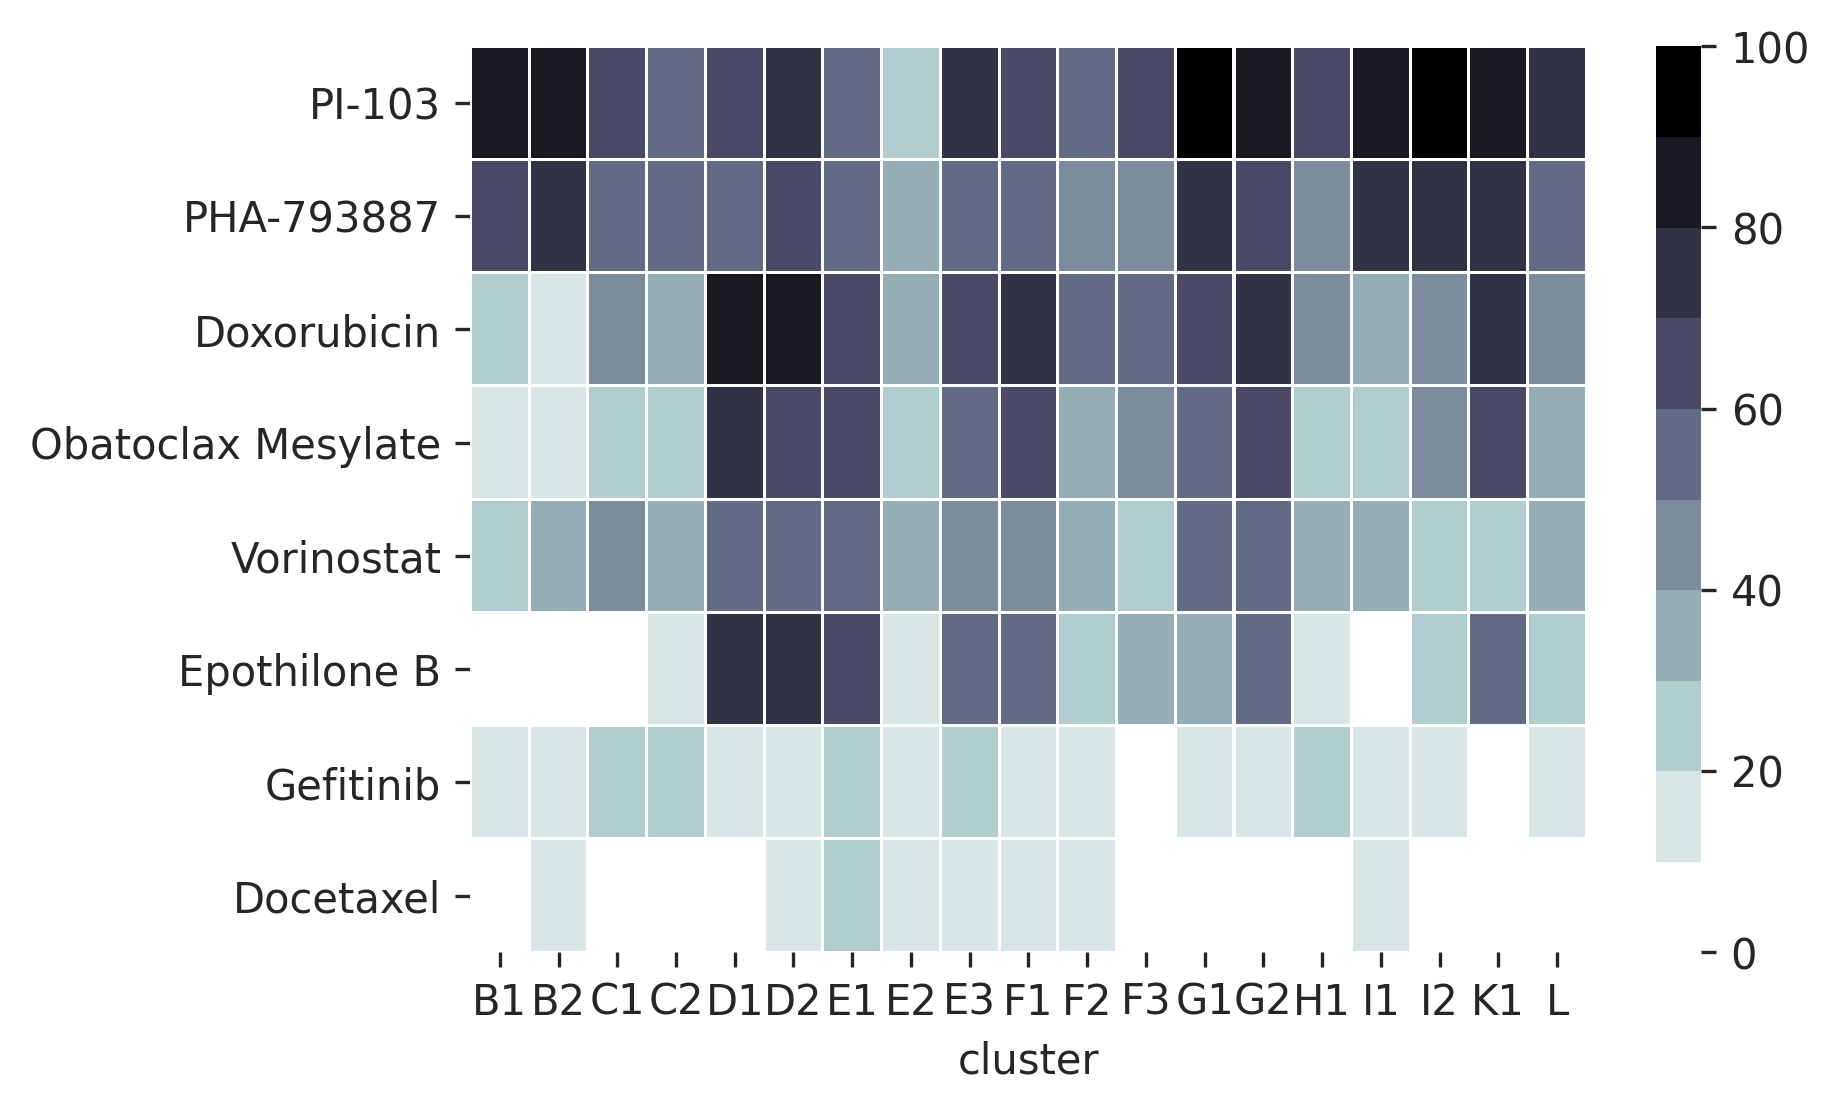

In [15]:
single_drug_id_list = ['1007', '133', '201', '1010', '182', '301', '302', '1012']
single_drug_list = ['Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib', 'Obatoclax Mesylate', 'PHA-793887', 'PI-103', 'Vorinostat']

temp_df = (freq_df.loc[freq_df.index != 'HN182'] >= freq_cutoff).sum()
selected_clusters = temp_df.index[temp_df > 0]

cmap = plt.cm.get_cmap('bone_r', 10)
selected_kill_df = pred_kill_df.loc[selected_clusters, single_drug_id_list]
selected_kill_df.columns = single_drug_list
selected_kill_df = selected_kill_df[selected_kill_df.sum().sort_values(ascending=False).index]

sns.heatmap(selected_kill_df.T, cmap=cmap, vmin=0, vmax=100, linewidth=0.5)

In [16]:
log2_median_ic50_df = drug_info_df.loc[single_drug_id_list][['Drug Name', ref_type]].reset_index().set_index('Drug Name')
log2_median_ic50_df.loc[selected_kill_df.sum().sort_values(ascending=False).index]

,Drug ID,log2_median_ic50_hn
PI-103,302,3.056464
PHA-793887,301,3.606539
Doxorubicin,133,-2.812230
Obatoclax Mesylate,182,-2.958665
Vorinostat,1012,0.711127
Epothilone B,201,-8.520806
Gefitinib,1010,-1.374969
Docetaxel,1007,-9.792998


In [17]:
print (ref_type)
log2_median_ic50s = log2_median_ic50_df.loc[selected_kill_df.sum().sort_values(ascending=False).index][ref_type].values
median_ic50s = np.power(2, log2_median_ic50s)

for x in median_ic50s:
    print ('{:f}'.format(x))


log2_median_ic50_hn
8.319312
12.180817
0.142375
0.128633
1.637083
0.002723
0.385561
0.001127


In [18]:
temp_df = freq_df.loc[freq_df.index != 'HN182'].stack().reset_index()
temp_df = temp_df[temp_df[0] >= freq_cutoff]
patient_cluster_dict = dict(zip(temp_df['cluster'], temp_df['patient_id']))

In [19]:
patient_list = sorted(list(set(temp_df['patient_id'])))
cluster_list = temp_df['cluster'].values

cmap = plt.cm.get_cmap('tab10', 10)
patient_color_dict = dict(zip(patient_list, [cmap(c) for c in range(len(patient_list))]))

In [20]:
patient_list

['HN120', 'HN137', 'HN148', 'HN159', 'HN160']

In [21]:
col_colors = [patient_color_dict[patient_cluster_dict[c]] for c in cluster_list]

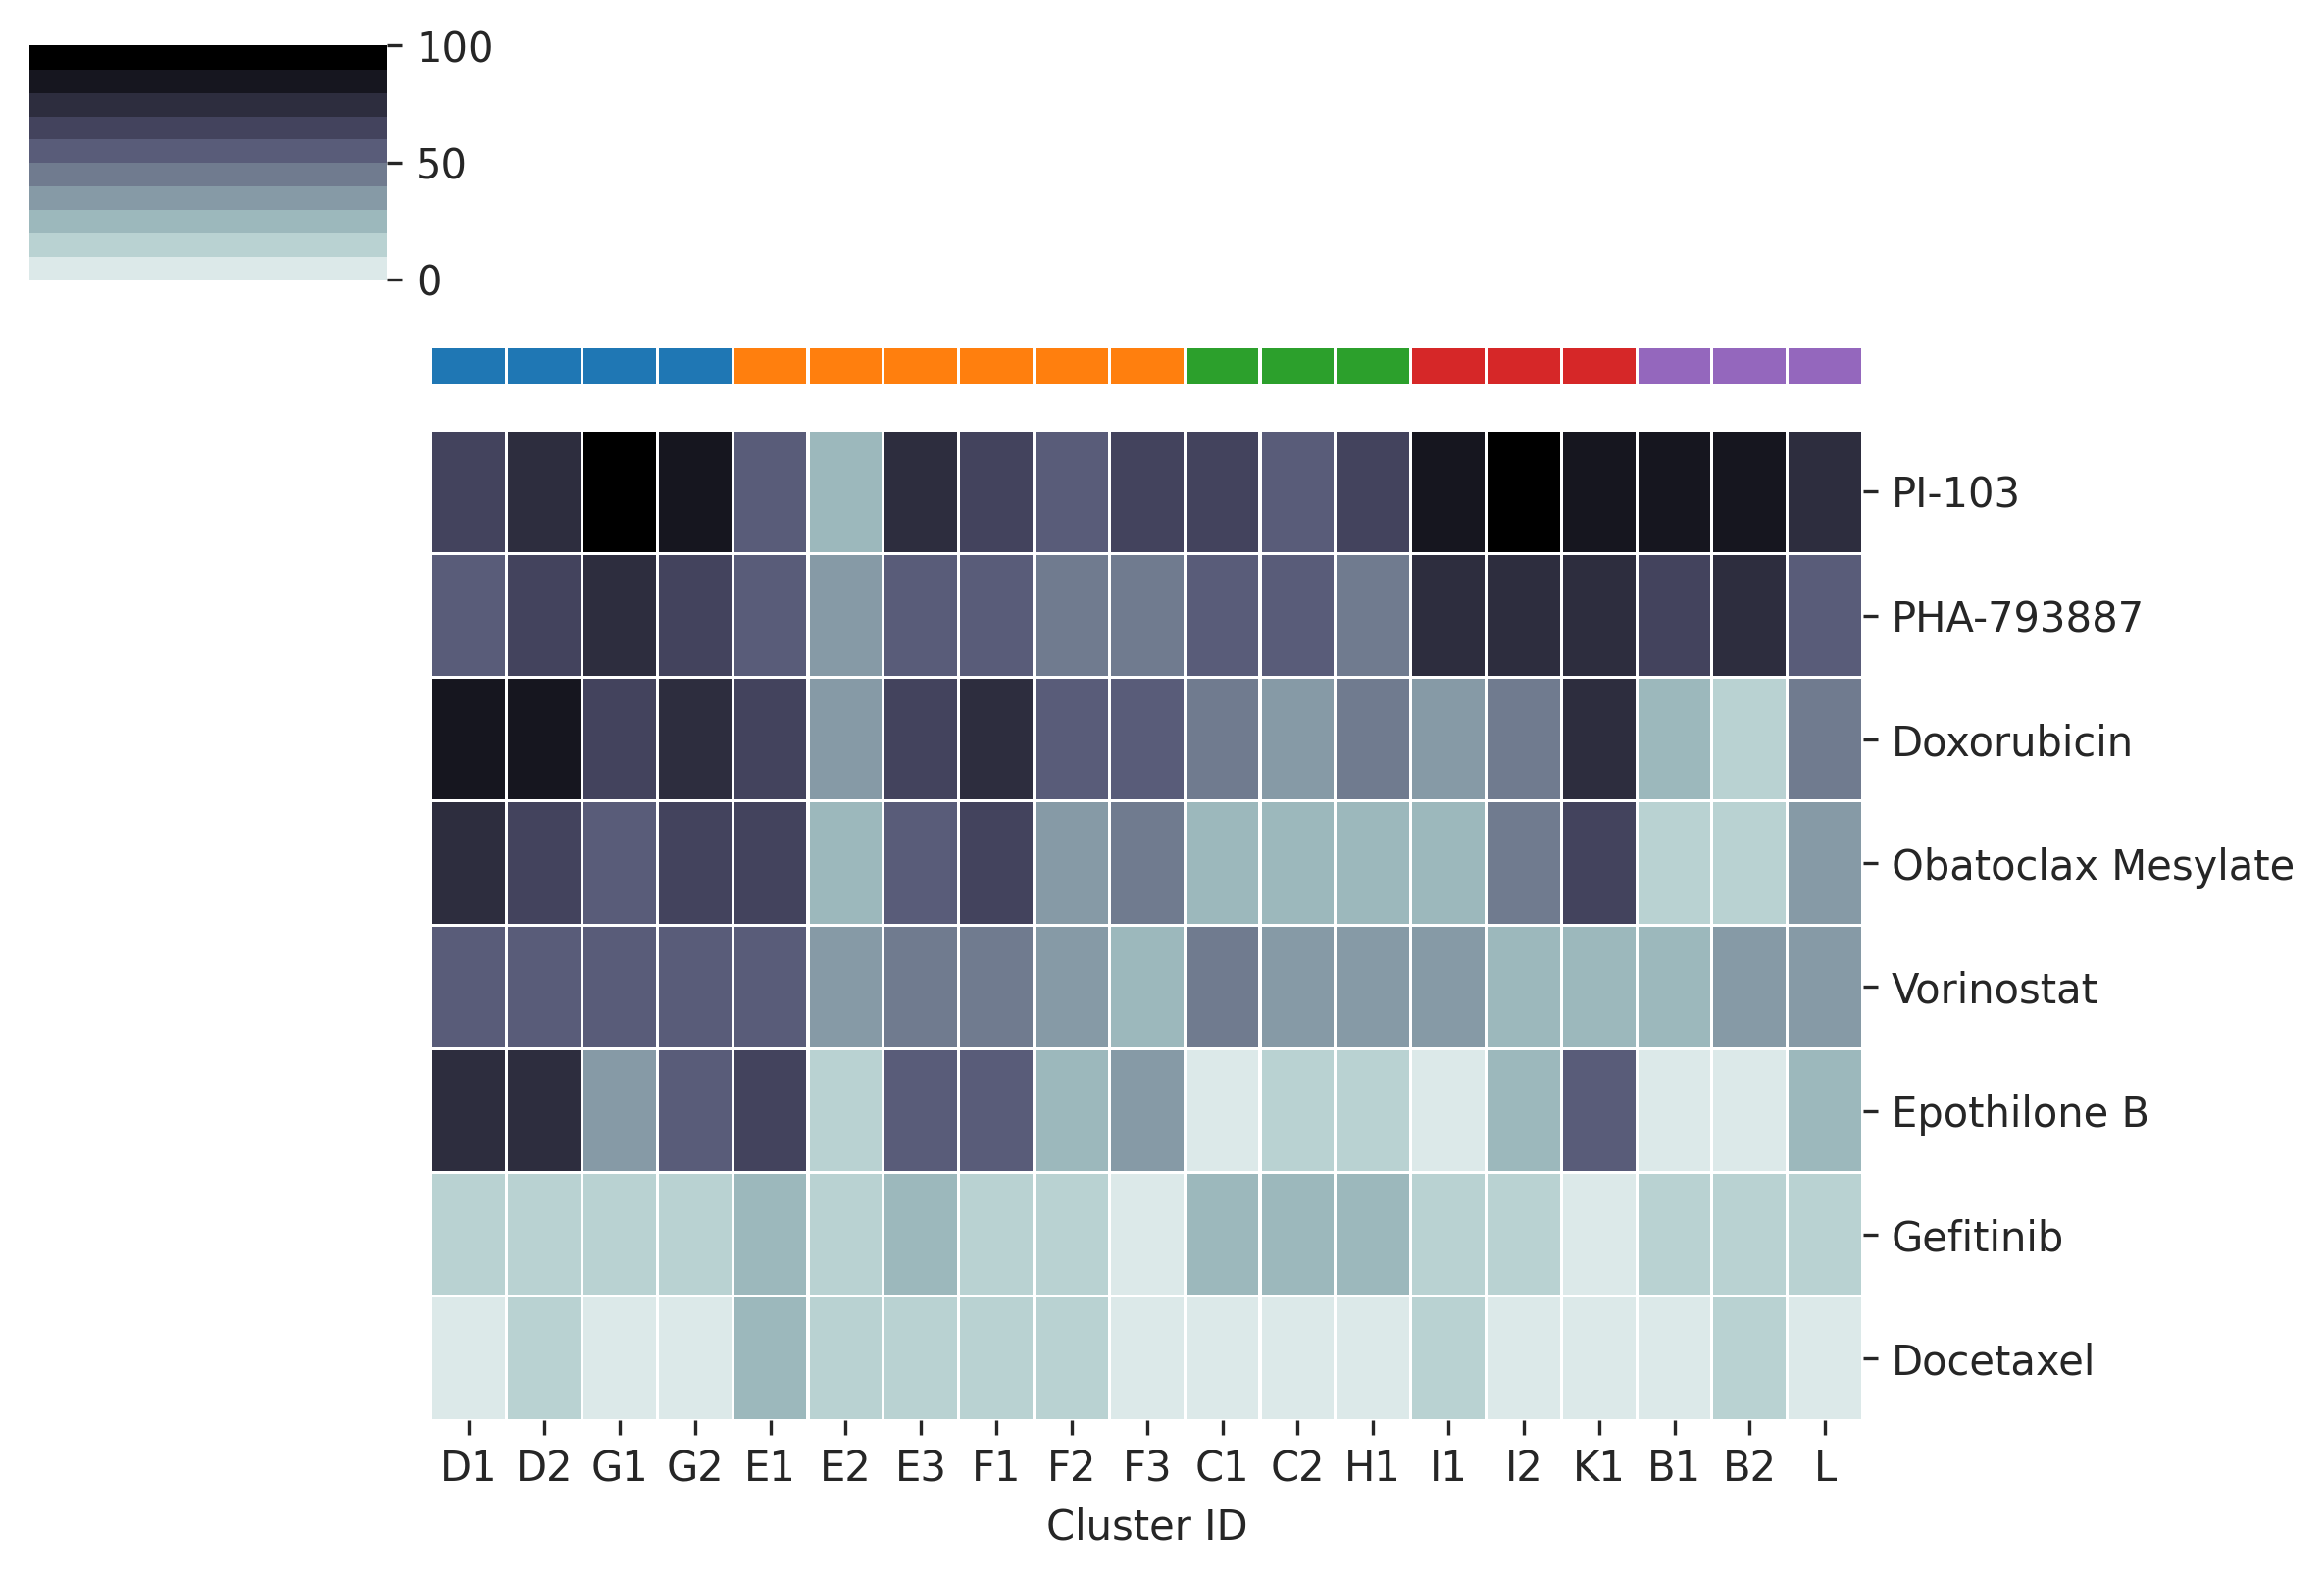

In [22]:
cmap = plt.cm.get_cmap('bone_r', 11)
cg = sns.clustermap(selected_kill_df.T[cluster_list], cmap=cmap, vmin=-10, vmax=100, linewidth=0.5, row_cluster=False, col_cluster=False, col_colors=col_colors, figsize=(8,5.5))

_ = cg.ax_heatmap.set_xlabel('Cluster ID')
plt.tight_layout()
# _ = cg.cax.set_visible(False)

# cg.savefig('../figure/Fig4A_heatmap_cluster_pred.svg')

Save results

In [23]:
if dosage_shifted:
    single_drug_pred_df.to_csv(out_dir + 'pred_drug_kill_{}_{}_shifted.csv'.format(ref_type, model_name), index=False)
else:
    single_drug_pred_df.to_csv(out_dir + 'pred_drug_kill_{}_{}.csv'.format(ref_type, model_name), index=False)